In [62]:
import pdb
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from datetime import datetime, timedelta
from tabulate import tabulate
from mcap.reader import make_reader
from mcap_ros2.decoder import DecoderFactory
from mcap.well_known import MessageEncoding, SchemaEncoding
from mcap.records import Message, Schema
from mcap_ros2.reader import read_ros2_messages

In [63]:
class UnknownMessageException(Exception):
    pass

In [64]:
"""
Global variables: change by setiing differnt fps. windows lengh 

"""

#Sensor config
FPS_ERROR = 5/100 # percentage 
SENSOR_FPS = 20 
sensor_delay = 1/SENSOR_FPS
window_seconds = 15 

# Define expected fps per topic
expected_fps = {
    '/cam1':   20,   #20 fps * 60s = 1200 frames
    '/cam2':   20,
    '/robin':  20,
    '/falcon': 20
}

In [65]:
def time_window(stamps, start_ts, end_ts):
    """
    Returns all timestamps within the provided time window. This function is necessary because
    not all topics start sending at the same time, probably due to different starting times.

    Args:
        stamps (dict): A dictionary with the topic name as keys and list of timestamps as values
        start_ts (datetime): The start of the time window
        end_ts (datetime): The end of the time window
    Returns:
        dict[str, np.array(datetime)]: Dictionary with all timestamps in a certain window for each topic
    """
    window_stamps = {}
    for topic in stamps:
        # cast list of timestamps to np.array
        topic_stamps = np.array(stamps[topic])

        # use only timestamps within the provided window
        mask = (topic_stamps >= start_ts) & (topic_stamps < end_ts)
        window_stamps[topic] = topic_stamps[mask]

    return window_stamps

In [66]:
def find_mcap_file():
    # Find all .mcap files in the current directory
    base_dir = os.getcwd()
    mcap_files = glob.glob(os.path.join(base_dir, "*.mcap"))
    
    if not mcap_files:
        print("No .mcap files found in this directory!")
        return None
    
    if len(mcap_files) > 1:
        print("Multiple .mcap files in this directory!")
        return None

    mcap_file = mcap_files[0]
    print(f"Found {mcap_file}")
    
    return mcap_file

In [67]:
def frame_loss(start_ts, end_ts, timestamps):
    # Calculate window length in seconds
    window_stamps = time_window(timestamps, start_ts, end_ts)
    window_length = (end_ts - start_ts).total_seconds()
    
    # --- Formula explanation ---
    print("Formula: Expected = FPS × window_length [s]")
    print(f"Window length = {window_length:.2f} s\n")
    
    # --- Collect table data ---
    rows = []
    for topic in window_stamps:
        f_exp = expected_fps[topic]
        n_expected = f_exp * window_length
        n_actual = len(window_stamps[topic])
        loss_percent = ((n_expected - n_actual) / n_expected) * 100
    
        rows.append([
            topic,
            f_exp,
            f"{n_expected:.0f}",
            n_actual,
            f"{loss_percent:.2f}%",
        ])
        
    print(tabulate(
        rows,
        headers=["Topic", "FPS", "Expected Frames", "Actual Frames", "Frame Loss (%)"],
        tablefmt="fancy_grid"
    ))

In [68]:
def get_message_timestamps(mcap_file, topics):
    """
    Returns a dictionary with the header timestamps for all provided topics

    Args:
        mcap_file (str): Path to the mcap file containing the rosbag
        topics (List[str]): List of all topics which should be parsed
    Returns:
        acquisition_stamps (Dict[str, List[datetime]]): Dicationary with the acquisition timestamp of all messages for all topics
        arrival_stamps (Dict[str, List[datetime]]): Dicationary with the arrival timestamp of all messages for all topics
    """
    acquisition_stamps = {t: [] for t in topics}
    arrival_stamps = {t: [] for t in topics}
    

    # Read messages
    with open(mcap_file, "rb") as f:
        reader = make_reader(f, decoder_factories=[DecoderFactory()])

        for schema, channel, message, decoded_message in reader.iter_decoded_messages():
            if channel.topic in topics:
                # acquisition timestamp
                seconds = decoded_message.header.stamp.sec
                nanoseconds = decoded_message.header.stamp.nanosec
                ts = datetime.fromtimestamp(seconds) + timedelta(microseconds=nanoseconds / 1000)
                acquisition_stamps[channel.topic].append(ts)

                # arrival timestamp
                arrival_stamps[channel.topic].append(datetime.fromtimestamp(message.log_time / 1e9))

    return acquisition_stamps, arrival_stamps

In [69]:
def parse_ptp_message(msg):
    """
    Parse a PTP message string like:
        "String(data=ptp_lidar:\n/dev/ptp3: System clock: 1762529168.954108068)"

    Returns:
        (data_field, device, datetime_utc)
        or None if parsing fails
    """
    _ts_re = re.compile(
        r"(?P<prefix>.*?data=)?(?P<data>[^\n:()]+?)\s*:\s*\\?n?"
        r"(?P<device>[^:()]+?)\s*:\s*[^:()]*?:\s*(?P<ts>\d+\.\d+)",
        re.DOTALL
    )
    
    m = _ts_re.search(msg)
    
    if not m:
        raise UnknownMessageException()
    
    data = m.group("data").strip()
    device = m.group("device").strip()
    
    ts = m.group("ts")
    sec_str, ns_str = ts.split(".")
    seconds = int(sec_str)
    ns_str = ns_str.ljust(9, "0")[:9]
    nanoseconds = int(ns_str)
    ts = datetime.fromtimestamp(seconds) + timedelta(microseconds=nanoseconds / 1000)
    
    return {
        'device': data + ' ' + device,
        'ts': ts
    }

In [70]:
def parse_sync_message(msg):
    """
    Parse a PTP message string like:
        "String(data: 'phc2sys_cam:\nphc2sys[22393.096]: CLOCK_REALTIME phc offset 9 s2 freq  +22977 delay    853')"

    Returns:
        dictionary with info
    """
    pattern = r"phc2sys_(\w+):\s+phc2sys\[\d+\.\d+\]: (\S+) phc offset\s+([-\d]+) s2 freq\s+([+-]?\d+) delay\s+(\d+)"
    match = re.search(pattern, str(msg))

    device = match.group(1)       # cam, lidar, etc.
    nic = match.group(2)   # CLOCK_REALTIME or NIC name
    offset = int(match.group(3))  # offset in ns
    freq_adj = int(match.group(4))    # frequency adjustment in ppb
    delay = int(match.group(5))   # delay in ns

    return {
        'device': device,
        'nic': nic,
        'offset': offset,
        'freq_adj': freq_adj,
        'delay': delay
    }

In [71]:
def parse_synchronization_messages(mcap_file):
    ptp_info = []
    phc_info = []
    
    with open(mcap_file, "rb") as f:
        reader = make_reader(f, decoder_factories=[DecoderFactory()])
        
        for schema, channel, message, decoded_message in reader.iter_decoded_messages():
            if channel.topic != "/ptp_combined_data":
                continue

            match = re.search(r"String\(data=([^\)]+)\)", str(decoded_message))
            data_field = match.group(1)

            if data_field.startswith('phc'):
                msg_info = parse_sync_message(str(decoded_message))
                phc_info.append(msg_info)
            elif data_field.startswith('ptp'):
                msg_info = parse_ptp_message(str(decoded_message))
                ptp_info.append(msg_info)           
            
    return ptp_info, phc_info

In [72]:
def summarize_topics(stamps):
    # Summarize & window each topic
    for topic, ts in stamps.items():
        print(f"\nTopic: {topic}")
        if not ts:
            print("  ⚠️ No messages found")
            continue

        start_time = ts[0]
        end_time = start_time + window_duration
        windowed_ts = [t for t in ts if start_time <= t <= end_time]

        # Length of the full message timeline
        total_length = ts[-1] - ts[0]

        print(f"  Total messages in the bag: {len(ts)}")
        print(f"  Full timeline length: {total_length}")
        print(f"  Window start:  {start_time}")
        print(f"  Window end:    {end_time}")
        print(f"  Window length: {window_duration}")
        #print(f"  Messages in 1s window: {len(windowed_ts)}")

In [73]:
def analyze_frequencies(stamps):
    print(f"FPS_ERROR = {FPS_ERROR:.5f} ({FPS_ERROR*100:.2f}%)")
    print(f"Global configuration: SENSOR_FPS = {SENSOR_FPS} Hz, Delay = {sensor_delay:.4f}s\n")
    
    table_data = []
    
    for topic in stamps:
        if len(stamps[topic]) == 0:
            print(f"No messages for topic {topic}")
            continue
            
        timestamps = np.array(stamps[topic])
        freq = len(timestamps) / (timestamps.max() - timestamps.min()).total_seconds()
        
        # Get expected fps for this topic
        topic_expected_fps = expected_fps.get(topic, SENSOR_FPS)
        
        # Calculate ±5% bounds
        lower_bound = topic_expected_fps * (1 - FPS_ERROR)
        upper_bound = topic_expected_fps * (1 + FPS_ERROR)
        
        # Check if within tolerance
        if lower_bound <= freq <= upper_bound:
            status = "✅ OK"
        else:
            status = "⚠️ WARNING"
        
        # Add formatted expected range with ± notation
        expected_str = (
            f"{topic_expected_fps:.2f} ({lower_bound:.2f}–{upper_bound:.2f}) = "
            f"{topic_expected_fps:.0f} ± {FPS_ERROR*100:.0f}%"
        )
        
        # Keep full precision for calculated frequency
        table_data.append([
            topic,
            freq,  # full number
            expected_str,
            status
        ])
    
    headers = ["Topic", "Calculated Frequency (Hz)", "Expected Frequency Range (Hz)", "Status"]
    print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))

In [74]:
def format_s_us_ns(x, pos=None):
    dt = mdates.num2date(x)  # convert matplotlib float to datetime
    seconds = dt.second
    micro = dt.microsecond
    ns = 0  # Python datetime only supports microseconds; nanoseconds can be added if you have a separate array
    return f"{seconds}:{micro:03d}"

## We want to analyze:
- message time stamps (time of arrival) - the time the message was received by ROS
- data acquisition time stamps (time of acquisition) - the time the data was acquired by the sensor
- ime of arrival x time of acquisition
- time of acquisition of sensors (e.g. time of arrival vs camera vs lidar vs system clock)

## Objective is to make sure that:
- data recorded is stable on time
  - use msg.header.timestamp
- no network congestion
  - delay between time of arrival and time of acquisition
- sensors time sync is stable
  - in ptp_combined_data phc2sys the first number is the offset between the 2 timers

## Where is the data?
- time of arrival: msg.log_time
- time of acquisition: msg.header (from sensor itself)
- time sync information in ptp_combined_data

In [75]:
# Define topics of interest
topics = ["/cam1", "/cam2", "/robin", "/falcon"]

# Define colors for plotting
cmap = plt.get_cmap("tab10") 
color_map = {topic: cmap(i % 10) for i, topic in enumerate(topics)}

# Duration of the time window
window_duration = timedelta(seconds=window_seconds)

# find mcap file
mcap_file = find_mcap_file()

# extract timestamps of each message
acquisition_timestamps, arrival_timestamps = get_message_timestamps(mcap_file, topics)

# extract synchroniziation info from ptp_combined_data
ptp_info, phc_info = parse_synchronization_messages(mcap_file)

# summarize topics
summarize_topics(acquisition_timestamps)

# analyze frequencies of topic messages
analyze_frequencies(acquisition_timestamps)

Found /home/mariia/Desktop/rosbag2_2025_11_14-15_03_34/rosbag2_2025_11_14-15_03_34_0.mcap

Topic: /cam1
  Total messages in the bag: 134
  Full timeline length: 0:00:06.650002
  Window start:  2025-11-14 16:03:33.136302
  Window end:    2025-11-14 16:03:48.136302
  Window length: 0:00:15

Topic: /cam2
  Total messages in the bag: 134
  Full timeline length: 0:00:06.650023
  Window start:  2025-11-14 16:03:33.119304
  Window end:    2025-11-14 16:03:48.119304
  Window length: 0:00:15

Topic: /robin
  Total messages in the bag: 134
  Full timeline length: 0:00:06.650078
  Window start:  2025-11-14 16:03:34.999983
  Window end:    2025-11-14 16:03:49.999983
  Window length: 0:00:15

Topic: /falcon
  Total messages in the bag: 134
  Full timeline length: 0:00:06.650155
  Window start:  2025-11-14 16:03:35.001150
  Window end:    2025-11-14 16:03:50.001150
  Window length: 0:00:15
FPS_ERROR = 0.05000 (5.00%)
Global configuration: SENSOR_FPS = 20 Hz, Delay = 0.0500s

╒═════════╤═════════════

## Stability of recorded data
The frequency of recorded data should always be roughly the same. The timestamp of recording is contained in the header timestamp of the messages

In [76]:
# compute delay between each consecutive message
delays = {}
for topic in topics:
    # compute delays in microseconds
    deltas = np.diff(np.array([ts.timestamp() for ts in acquisition_timestamps[topic]]))

    # convert to nanoseconds
    deltas = deltas * 1000
    delays[topic] = deltas

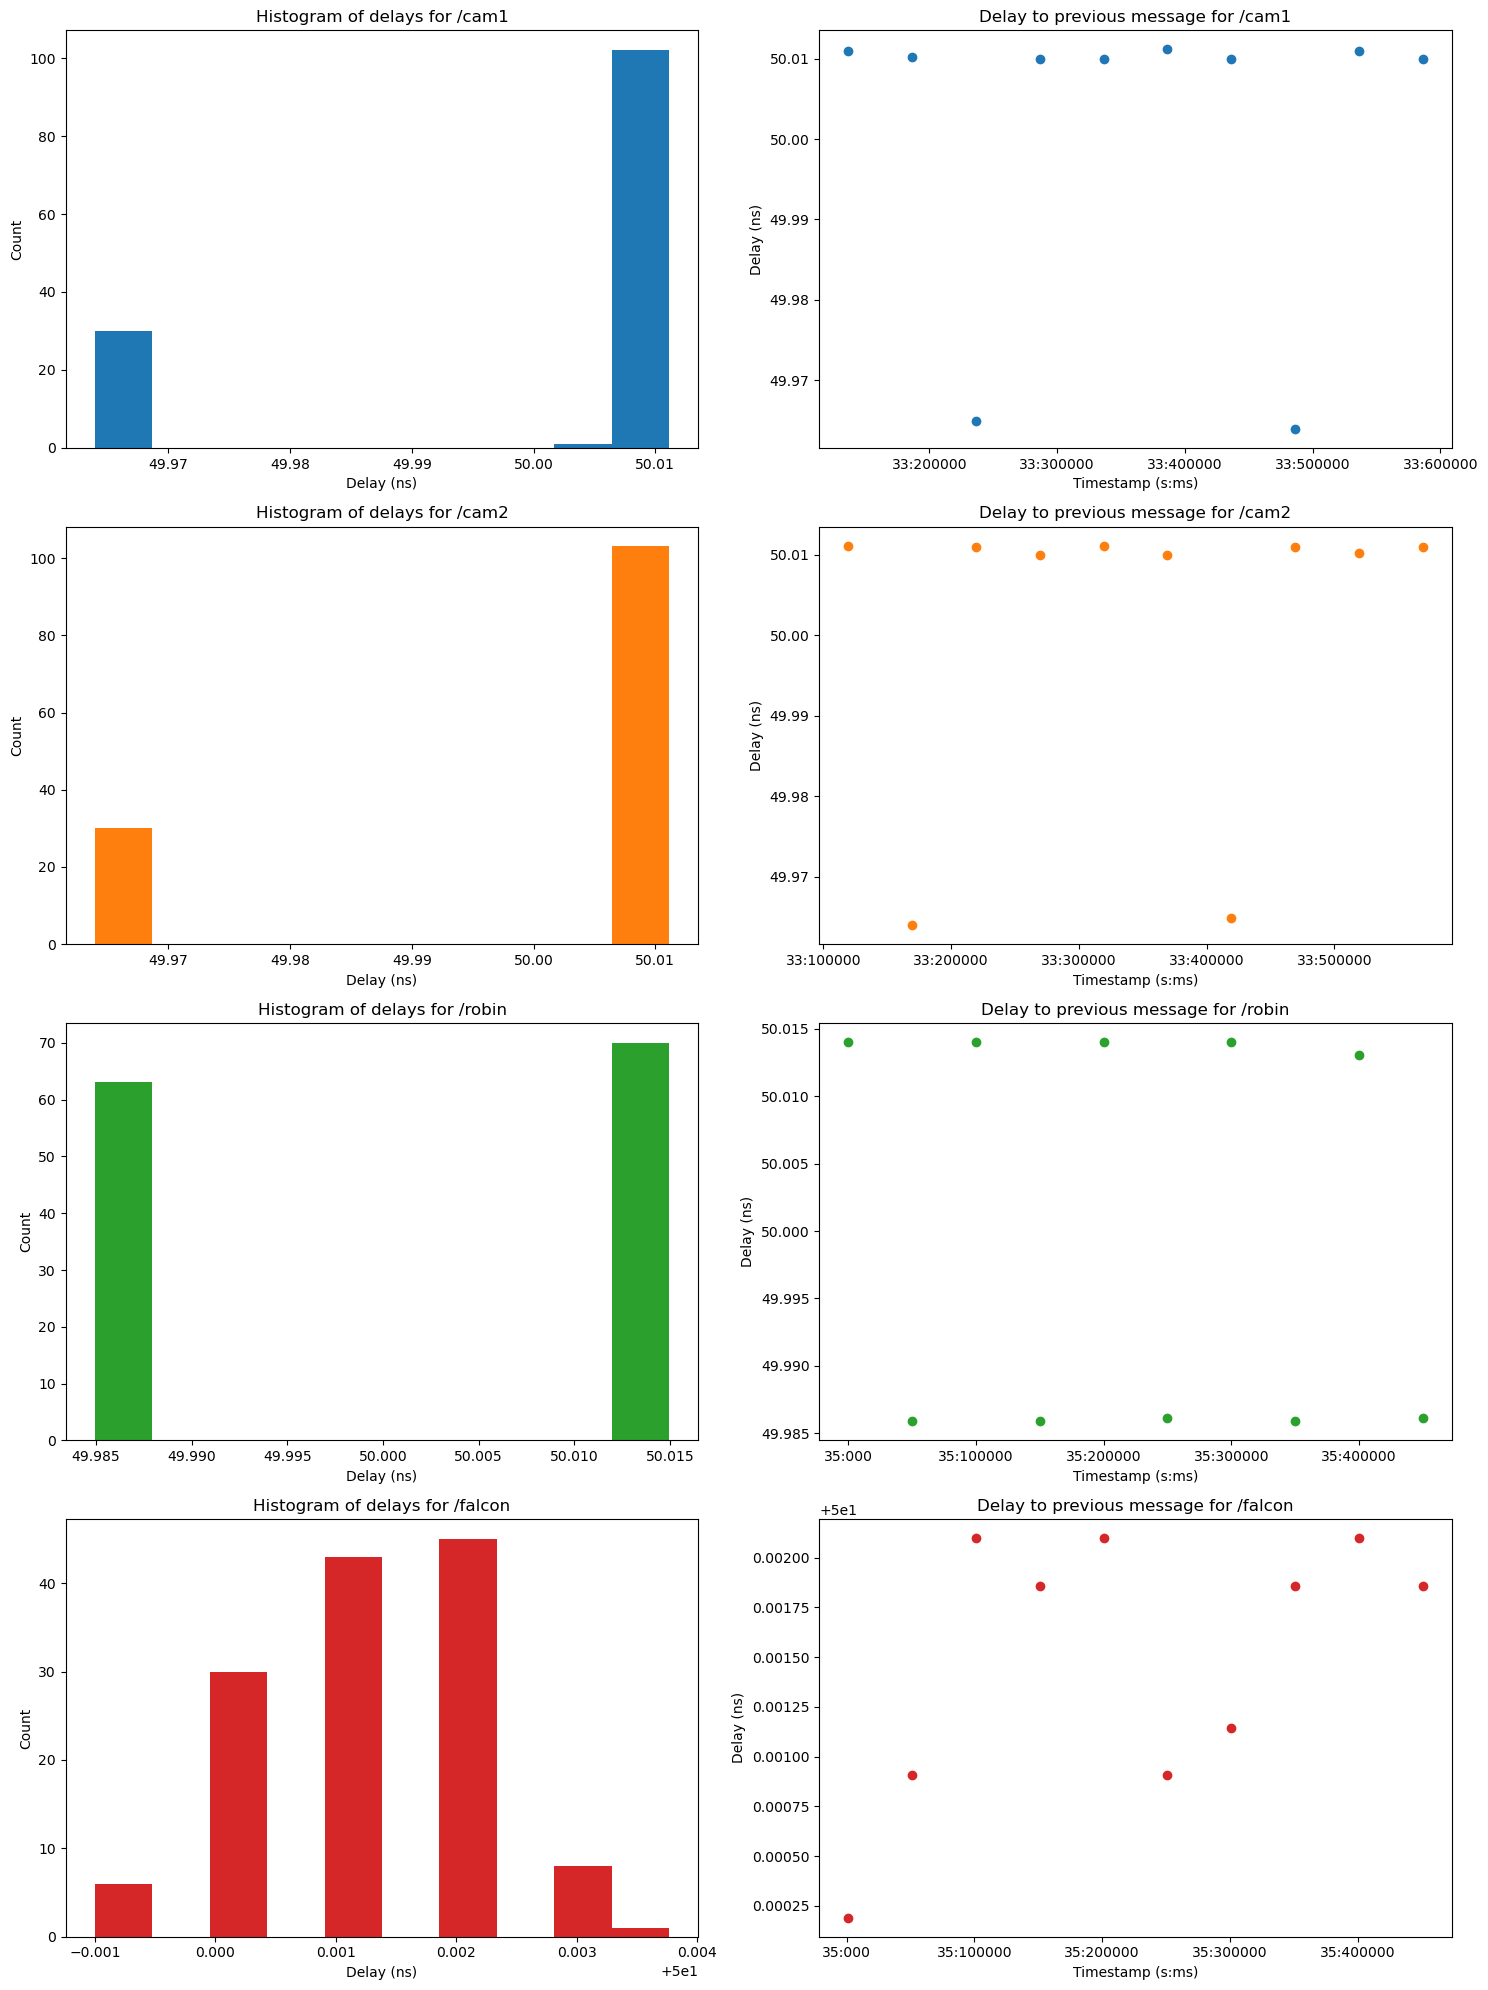

In [77]:
n = 10 # the number of individual datapoints to plot

fig, axes = plt.subplots(len(topics), 2, figsize=(15, 20))

for i, topic in enumerate(topics):
    # plot historgram of delays
    axes[i][0].hist(delays[topic], color=color_map[topic])
    axes[i][0].set_title(f"Histogram of delays for {topic}")
    axes[i][0].set_ylabel("Count")
    axes[i][0].set_xlabel("Delay (ns)")

    # plot individual message timestamps
    axes[i][1].scatter(acquisition_timestamps[topic][:n], delays[topic][:n], color=color_map[topic])
    axes[i][1].xaxis.set_major_formatter(plt.FuncFormatter(format_s_us_ns)) # foramat xtick datetime layout (ss:ms)
    axes[i][1].set_title(f"Delay to previous message for {topic}")
    axes[i][1].set_ylabel("Delay (ns)")
    axes[i][1].set_xlabel("Timestamp (s:ms)")

plt.tight_layout()

## Network Throughput
The delay between 'time of acquisition' (When the data was acquired by the sensor) and 'time of arrival' (When the system receives the ROS message) should always be in an acceptable range with no outliers where transportation takes longer than usual.

In [78]:
delay_dfs = {}
for topic in topics:
    delay_df = pd.DataFrame({
        'acquisition': acquisition_timestamps[topic],
        'arrival': arrival_timestamps[topic]
    })
    delay_df['delay'] = (delay_df['arrival'] - delay_df['acquisition']).astype(int)
    delay_dfs[topic] = delay_df

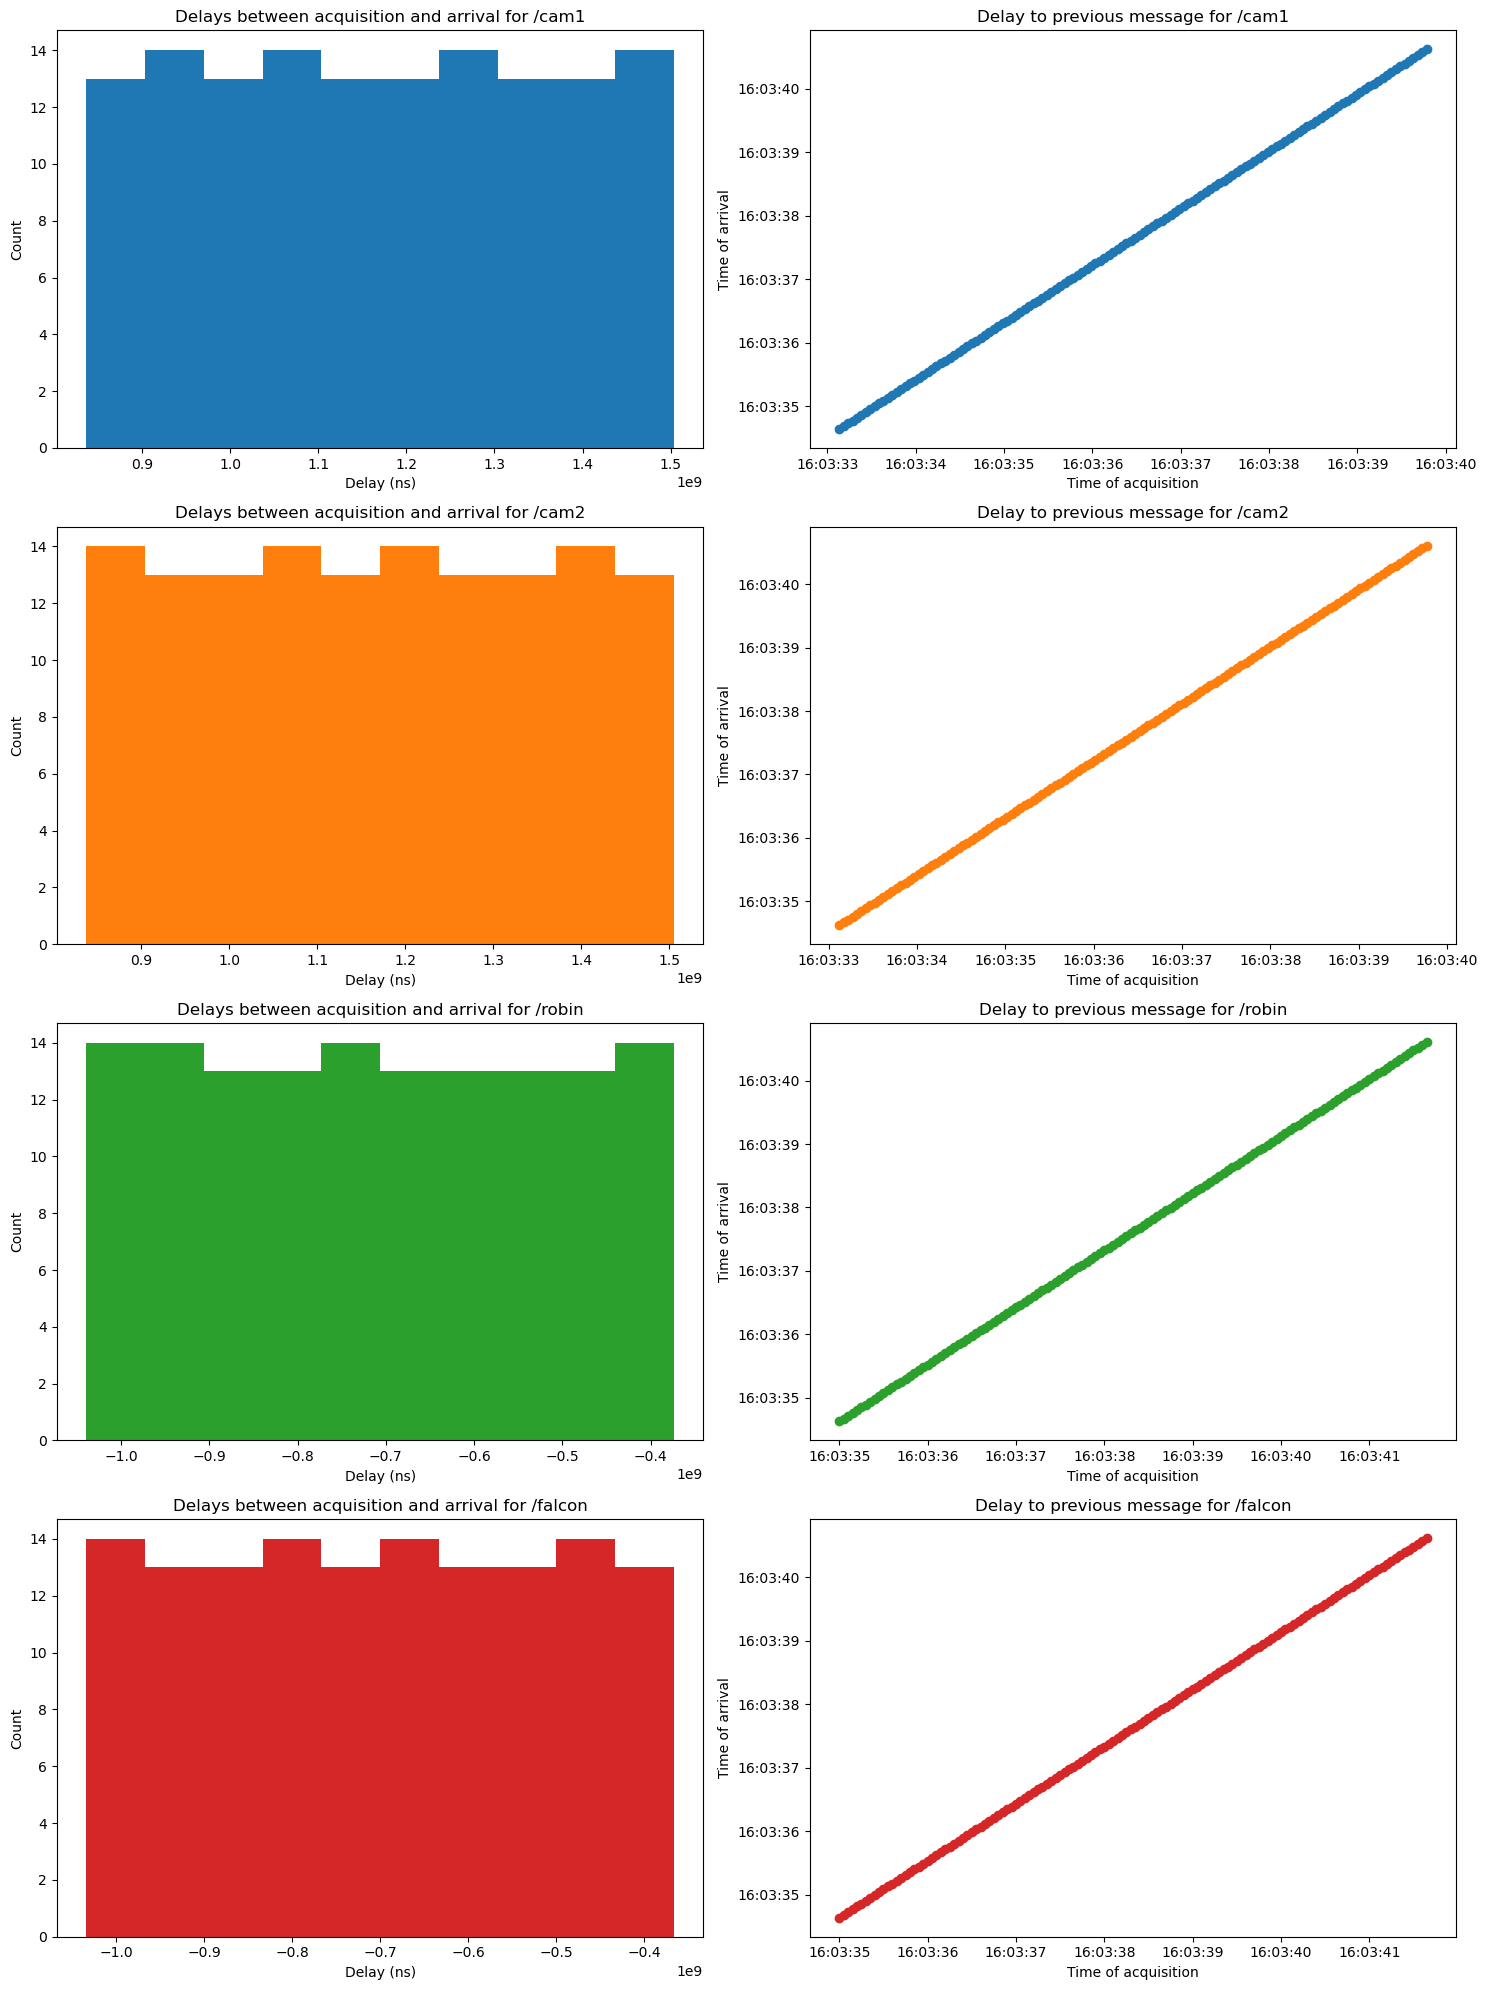

In [79]:
n = 10 # the number of individual datapoints to plot

fig, axes = plt.subplots(len(topics), 2, figsize=(15, 20))

for i, topic in enumerate(topics):
    # plot historgram of delays
    axes[i][0].hist(delay_dfs[topic]['delay'], color=color_map[topic])
    axes[i][0].set_title(f"Delays between acquisition and arrival for {topic}")
    axes[i][0].set_ylabel("Count")
    axes[i][0].set_xlabel("Delay (ns)")

    # plot individual message timestamps
    axes[i][1].scatter(delay_dfs[topic]['acquisition'], delay_dfs[topic]['arrival'],color=color_map[topic])
    axes[i][1].set_title(f"Delay to previous message for {topic}")
    axes[i][1].set_ylabel("Time of arrival")
    axes[i][1].set_xlabel("Time of acquisition")

plt.tight_layout()

## Synchronization
The PTP clocks of the different NICs should be synchronized.

In [80]:
# differences between ptp timestamps
ptp_info = unique_dicts = list({frozenset(d.items()): d for d in ptp_info}.values())

devices = set([info['device'] for info in ptp_info])
ptp_timestamps = {device: [] for device in devices}

for info in ptp_info:
    device_name = info['device']
    ptp_timestamps[device_name].append(info['ts'])

ptp_info_df = pd.DataFrame(ptp_timestamps)
ptp_info_df['delta (ns)'] = (ptp_info_df['ptp_lidar /dev/ptp3'] - ptp_info_df['ptp_camera /dev/ptp2']).astype("int64")

ptp_info_df

,ptp_lidar /dev/ptp3,ptp_camera /dev/ptp2,delta (ns)
0,2025-11-14 16:03:25.386840,2025-11-14 16:03:25.386817,23000
1,2025-11-14 16:03:27.053721,2025-11-14 16:03:27.053692,29000
2,2025-11-14 16:03:28.720662,2025-11-14 16:03:28.720641,21000
3,2025-11-14 16:03:30.387502,2025-11-14 16:03:30.387478,24000
4,2025-11-14 16:03:32.054364,2025-11-14 16:03:32.054335,29000


In [81]:
phc_info = list({frozenset(d.items()): d for d in phc_info}.values())
phc_info

[{'device': 'cam',
  'nic': 'CLOCK_REALTIME',
  'offset': -37,
  'freq_adj': 22950,
  'delay': 1085},
 {'device': 'lidar',
  'nic': 'enp9s0f1np1',
  'offset': -7,
  'freq_adj': -3,
  'delay': 3751},
 {'device': 'lidar',
  'nic': 'enp9s0f1np1',
  'offset': -9,
  'freq_adj': -8,
  'delay': 3750},
 {'device': 'cam',
  'nic': 'CLOCK_REALTIME',
  'offset': 47,
  'freq_adj': 23023,
  'delay': 864},
 {'device': 'lidar',
  'nic': 'enp9s0f1np1',
  'offset': 5,
  'freq_adj': 4,
  'delay': 3776},
 {'device': 'cam',
  'nic': 'CLOCK_REALTIME',
  'offset': -6,
  'freq_adj': 22984,
  'delay': 1091},
 {'device': 'lidar',
  'nic': 'enp9s0f1np1',
  'offset': -8,
  'freq_adj': -8,
  'delay': 3741},
 {'device': 'cam',
  'nic': 'CLOCK_REALTIME',
  'offset': 33,
  'freq_adj': 23022,
  'delay': 1096},
 {'device': 'lidar',
  'nic': 'enp9s0f1np1',
  'offset': 60,
  'freq_adj': 58,
  'delay': 3795},
 {'device': 'cam',
  'nic': 'CLOCK_REALTIME',
  'offset': 35,
  'freq_adj': 23034,
  'delay': 1102},
 {'device': 

## Frame Loss

In [54]:
start_ts = datetime(year=2025, month=11, day=14, hour=16, minute=3, second=34)
end_ts = datetime(year=2025, month=11, day=14, hour=16, minute=3, second=38)
frame_loss(start_ts, end_ts, acquisition_timestamps)

Formula: Expected = FPS × window_length [s]
Window length = 4.00 s

╒═════════╤═══════╤═══════════════════╤═════════════════╤══════════════════╕
│ Topic   │   FPS │   Expected Frames │   Actual Frames │ Frame Loss (%)   │
╞═════════╪═══════╪═══════════════════╪═════════════════╪══════════════════╡
│ /cam1   │    20 │                80 │              80 │ 0.00%            │
├─────────┼───────┼───────────────────┼─────────────────┼──────────────────┤
│ /cam2   │    20 │                80 │              80 │ 0.00%            │
├─────────┼───────┼───────────────────┼─────────────────┼──────────────────┤
│ /robin  │    20 │                80 │              60 │ 25.00%           │
├─────────┼───────┼───────────────────┼─────────────────┼──────────────────┤
│ /falcon │    20 │                80 │              60 │ 25.00%           │
╘═════════╧═══════╧═══════════════════╧═════════════════╧══════════════════╛
